## Problem Statement

We are interested in developing a robust machine learning system that leverages information coming from call center data.

Ultimately, we are looking for ways to improve the success rate for calls made to customers for any product that our clients offer. Towards this goal we are working on designing an ever evolving machine learning product that offers high success outcomes while offering interpretability for our clients to make informed decisions.

### Data Description:

The data comes from direct marketing efforts of a European banking institution. The marketing campaign involves making a phone call to a customer, often multiple times to ensure a product subscription, in this case a term deposit. Term deposits are usually short-term deposits with maturities ranging from one month to a few years. The customer must understand when buying a term deposit that they can withdraw their funds only after the term ends. All customer information that might reveal personal information is removed due to privacy concerns.

### Attributes:

age : age of customer (numeric)

job : type of job (categorical)

marital : marital status (categorical)

education (categorical)

default: has credit in default? (binary)

balance: average yearly balance, in euros (numeric)

housing: has a housing loan? (binary)

loan: has personal loan? (binary)

contact: contact communication type (categorical)

day: last contact day of the month (numeric)

month: last contact month of year (categorical)

duration: last contact duration, in seconds (numeric)

campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

Output (desired target):

y - has the client subscribed to a term deposit? (binary)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

# imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# basic models
import lazypredict
from lazypredict.Supervised import LazyClassifier

### Data Loading and Exploration
### Data Preprocessing

The Dataset has some categorical variables which requires transformation (i.e changing them to numerical representations).
Firstly, the binary variables will be transform using the Label encoder. 


In [2]:
# Read in Dataset
Data = pd.read_csv('C:\\Users\\Public\\term-deposit-marketing-2020.csv')
Dataset = Data.copy()

In [3]:
print(Dataset.shape)
Dataset.head()

(40000, 14)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [4]:
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


In [5]:
# see if there are duplicates rows in the data
sum(Dataset.duplicated())

0

In [6]:
Dataset.describe()

,age,balance,day,duration,campaign
count,40000.00,40000.00,40000.00,40000.00,40000.00
mean,40.54,1274.28,16.02,254.82,2.88
std,9.64,2903.77,8.28,259.37,3.24
min,19.00,-8019.00,1.00,0.00,1.00
25%,33.00,54.00,8.00,100.00,1.00
50%,39.00,407.00,17.00,175.00,2.00
75%,48.00,1319.00,21.00,313.00,3.00
max,95.00,102127.00,31.00,4918.00,63.00


Dataset has:
* no missing, null value and no duplicated row
* contains 40000 entries(rows) and a total of 14 columns
* 8 catagoral and 5 numeric features
* 13 features and the targt (y)
* its categorical features are both ordinal and norminal
* the numerical feature, 'balance' has some negative values
* the numerical feature, 'duration' has some zeros

In [7]:
# checking if the customers with negative balances subscribed to term deposit
print('balance:')
print(Dataset[Dataset['balance']<=0]['y'].value_counts())

balance:
no     6564
yes     376
Name: y, dtype: int64


In [8]:
# checking if the customers with zero duration subscribed to term deposit
print('duration:')
print(Dataset[Dataset['duration']==0]['y'].value_counts())

duration:
no    3
Name: y, dtype: int64


no    0.93
yes   0.07
Name: y, dtype: float64


<AxesSubplot:>

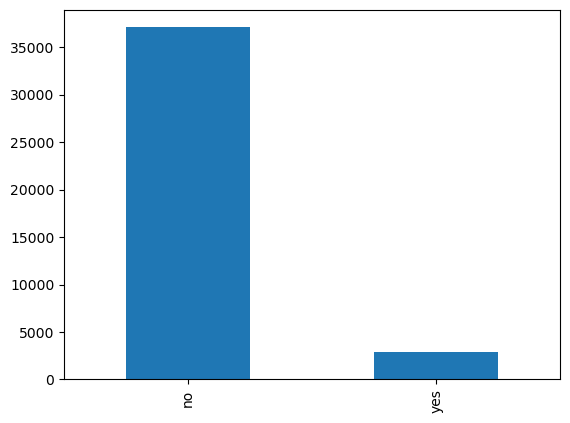

In [9]:
print(Dataset['y'].value_counts(normalize=True))
Dataset['y'].value_counts().plot.bar()

* The Dataset has an imbalance distribution of the target 'y', with 92% not subscribed and 7% subscribed

In [10]:
# define categorical and numerical features

categorical_col = []
numerical_col = []
for col in Dataset.columns:
  if Dataset[col].dtype == 'object':
    categorical_col.append(col)
  elif Dataset[col].dtype == 'int64':
    numerical_col.append(col)
print(f'Categorical columns: {categorical_col}')
print(f'Numerical columns: {numerical_col}')

Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y']
Numerical columns: ['age', 'balance', 'day', 'duration', 'campaign']


In [11]:
# Check for unique labels in each CATEOGRICAL column
for col in Dataset.columns:
    if(Dataset[col].dtype.name != 'object'): continue
    print(f'{col}: {len(Dataset[col].unique())} unique values\n')
    print(f'{Dataset[col].unique()}\n')
    print('----------------------------------------------------------------------\n')

job: 12 unique values

['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

----------------------------------------------------------------------

marital: 3 unique values

['married' 'single' 'divorced']

----------------------------------------------------------------------

education: 4 unique values

['tertiary' 'secondary' 'unknown' 'primary']

----------------------------------------------------------------------

default: 2 unique values

['no' 'yes']

----------------------------------------------------------------------

housing: 2 unique values

['yes' 'no']

----------------------------------------------------------------------

loan: 2 unique values

['no' 'yes']

----------------------------------------------------------------------

contact: 3 unique values

['unknown' 'cellular' 'telephone']

----------------------------------------------------------------------

month: 11 u

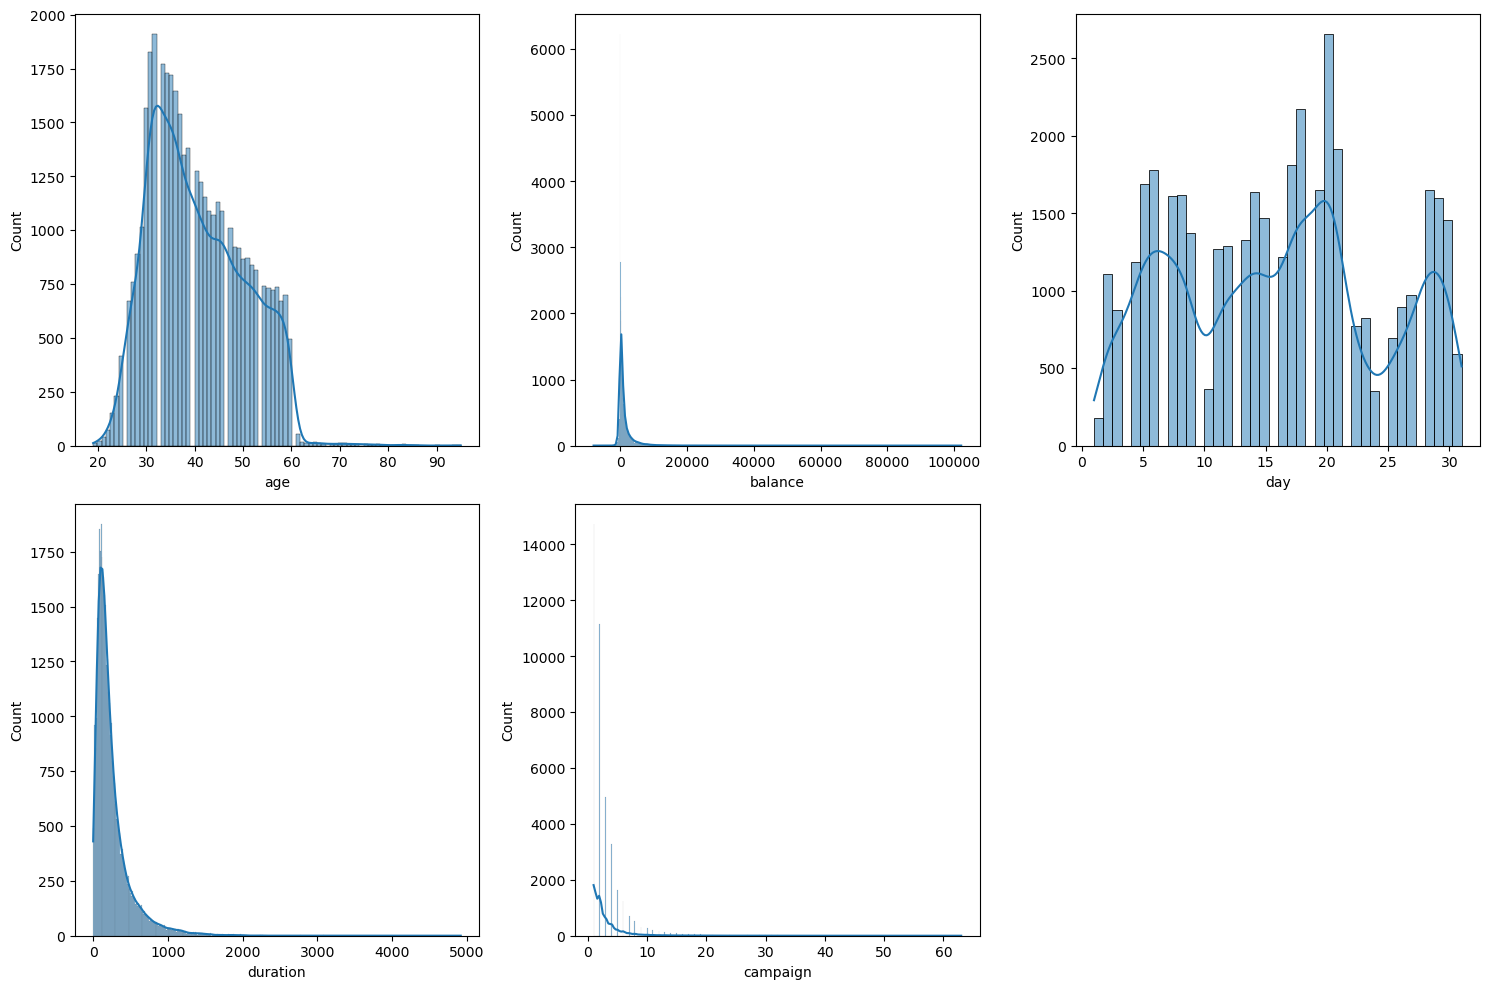

In [12]:
# distributions of numerical data

plt.figure(figsize=(15,10))
i = 1 
for col in numerical_col:
  ax = plt.subplot(2,3,i)
  sns.histplot(data=Dataset, x=col, kde=True)
  i+=1
plt.tight_layout()
plt.show()

Observation: from the above histograms we can see that:

* Most of the customers are aged between 30 and 50.
* Majority of the customers have a 'balance' below 10k
* Most calls 'duration' are usually between 0 to 500 secs.
* Between 0 and 10 contacts were made to customers during this campaigns.

Most of our numerical features have a right skewed and show the presence of outliers.

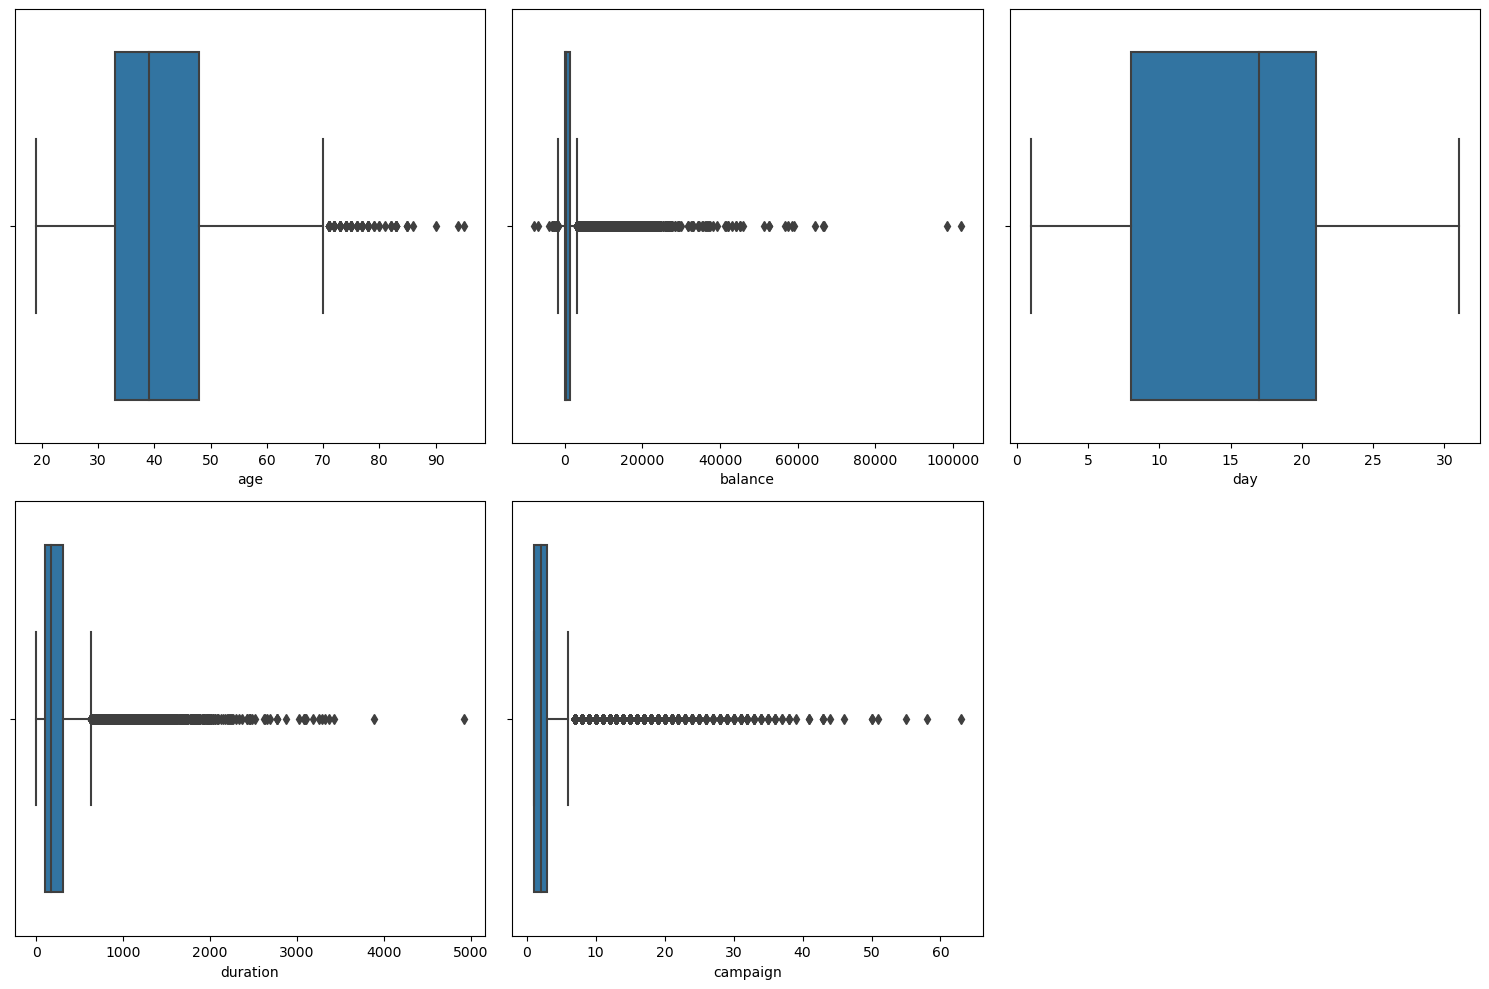

In [13]:
# using the boxplot to examine the outliers
plt.figure(figsize=(15,10))
i = 1 
for col in numerical_col:
  ax = plt.subplot(2,3,i)
  sns.boxplot(data=Dataset, x=col)
  i+=1
plt.tight_layout()
plt.show()

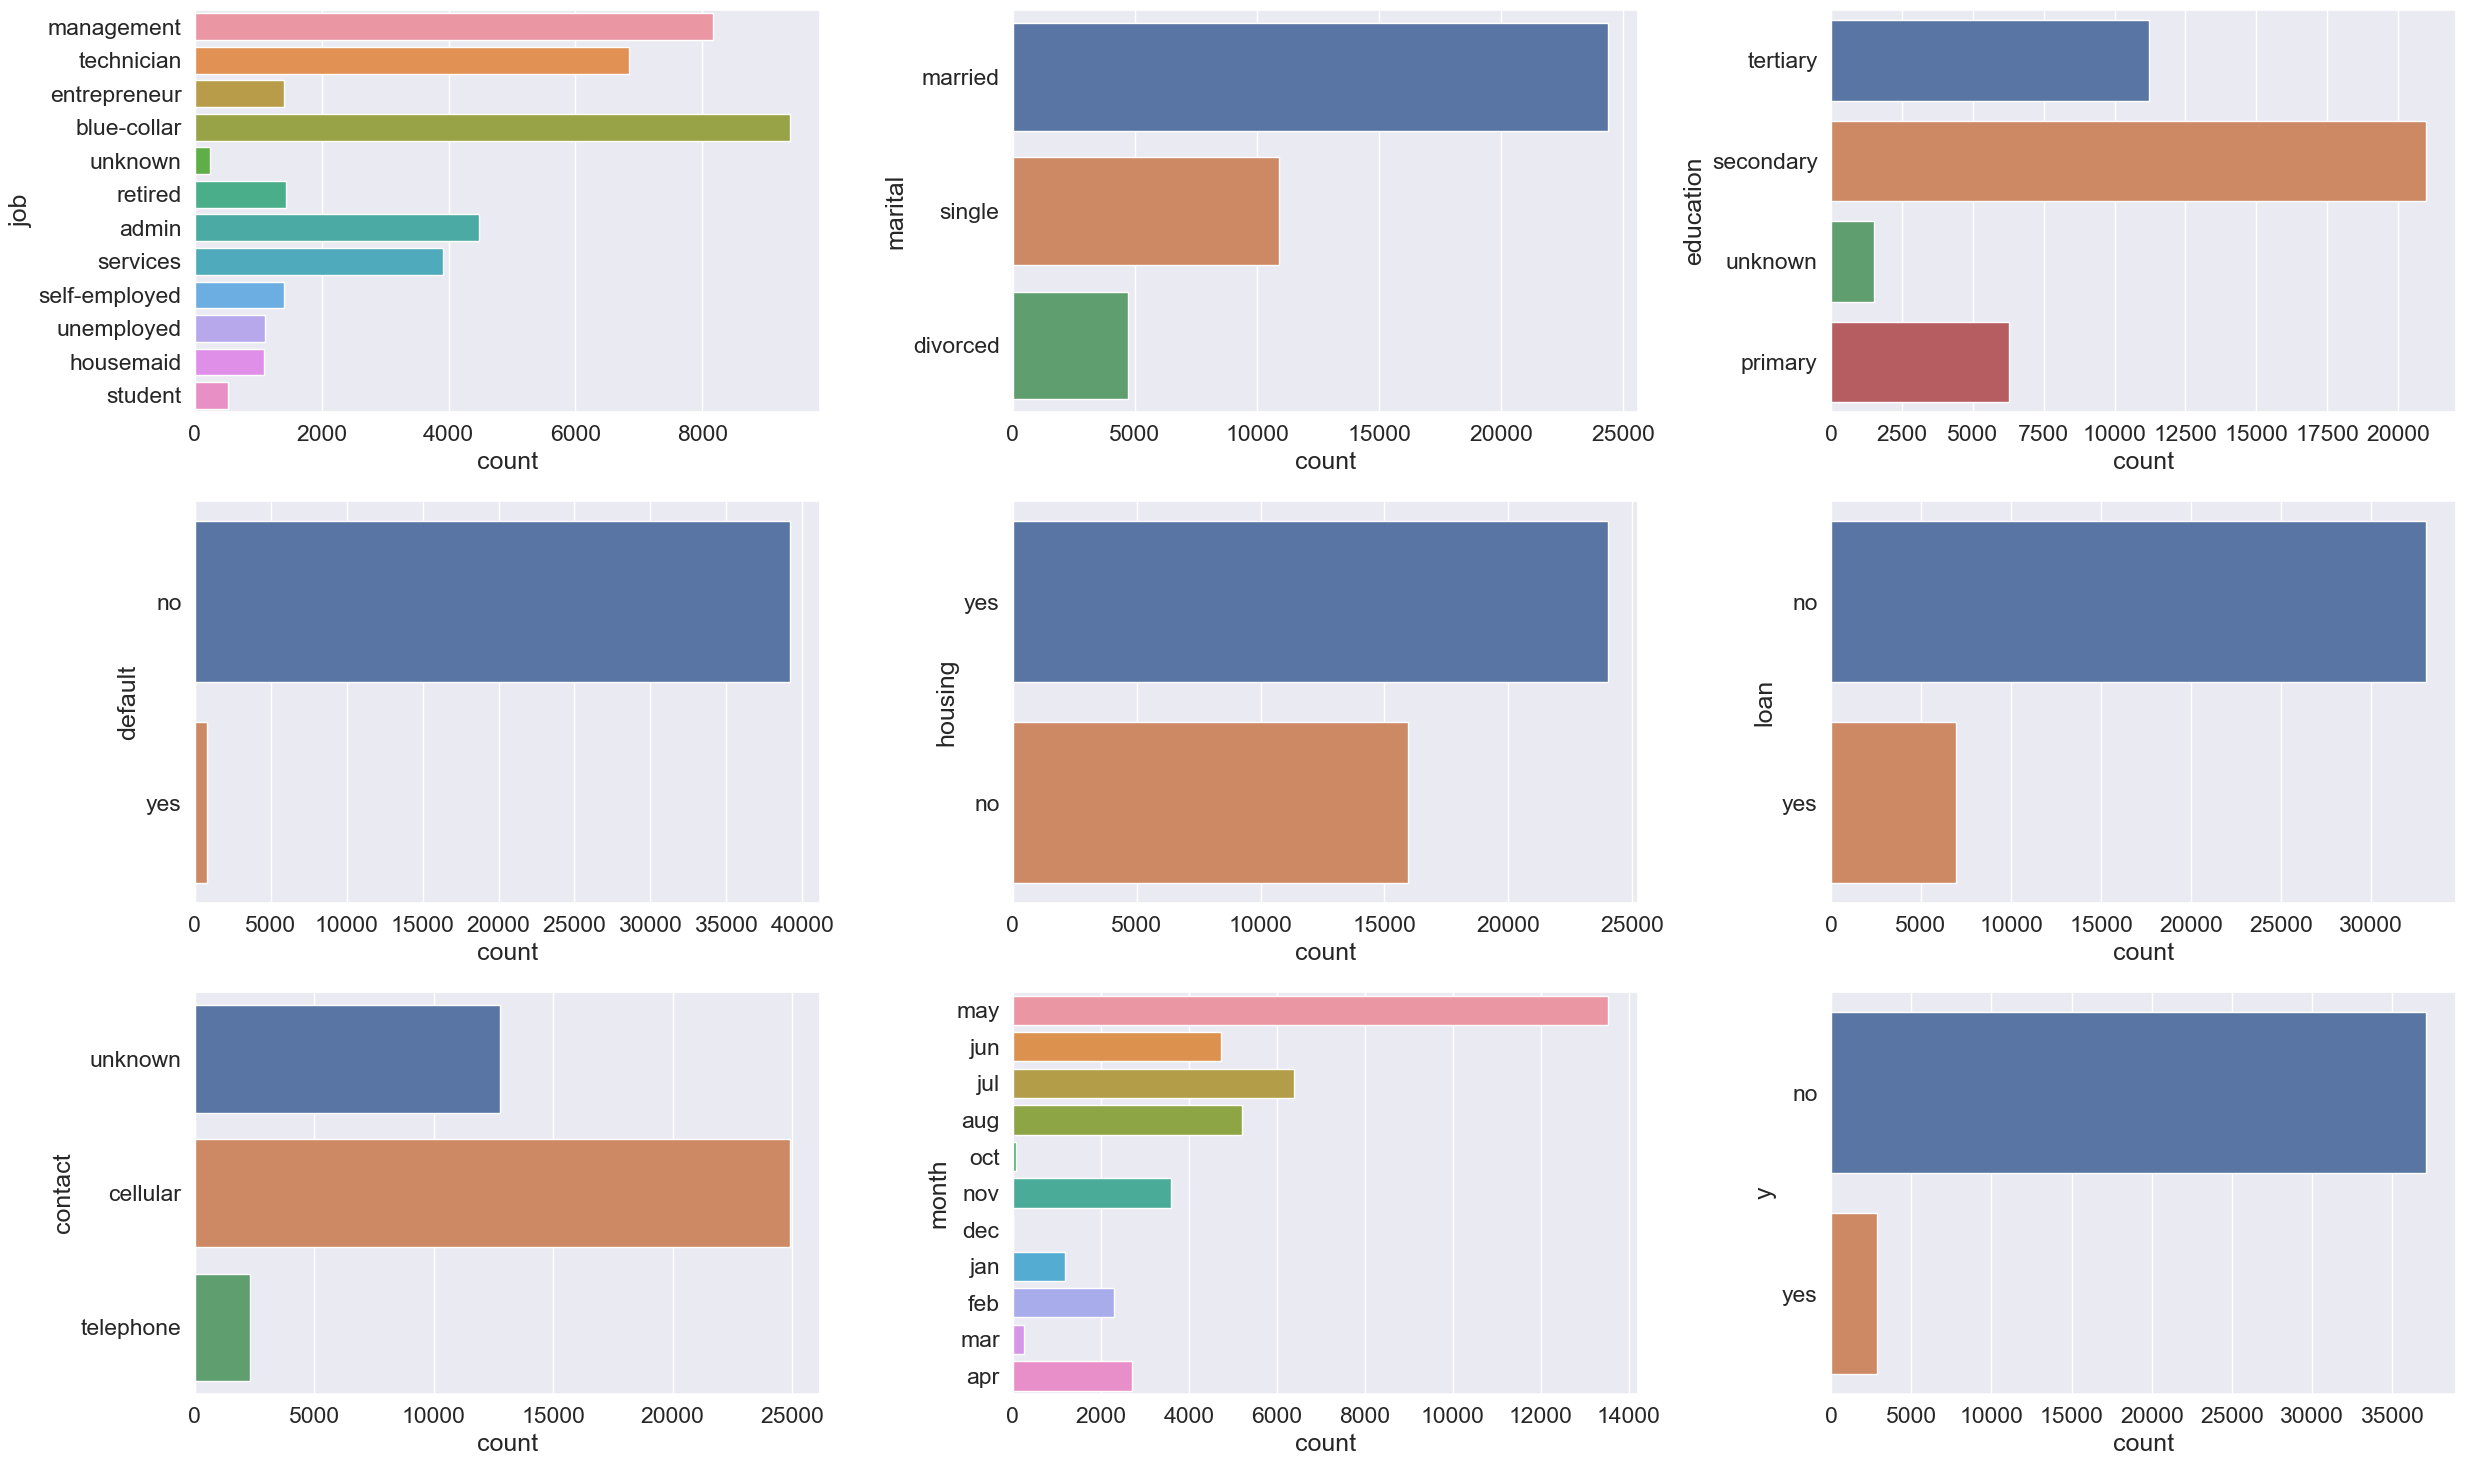

In [14]:
# countplots of categorical features
sns.set(font_scale = 1.5)
plt.figure(figsize=(25,15))
i=1
for col in categorical_col:
    ax = plt.subplot(3,3,i)
    sns.countplot(y=col,data=Dataset)
    i += 1
plt.tight_layout()
plt.show()

In [15]:
# let's examine the binary categorical columns
Bi_cols = ['loan','default','housing']
nrows = 40000
for i,col in enumerate(Bi_cols):
  v1 = Dataset[Dataset[col]=='yes'].shape[0]
  v2 = Dataset[Dataset[col]=='yes']['y'].value_counts()[0]
  if i==0:
    print(f'{v1}/{nrows} have a personal loan.')
    print(f'{v2}/{v1} have not subscribed to a term deposit.')
    print('---------------------------------------------------')
  elif i==1:
    print(f'{v1}/{nrows} have defaulted before.')
    print(f'{v2}/{v1} have not subscribed to a term deposit.')
    print('---------------------------------------------------')
  else:
    print(f'{v1}/{nrows} have a housing loan.')
    print(f'{v2}/{v1} have not subscribed to a term deposit.')
    print('---------------------------------------------------')

6930/40000 have a personal loan.
6550/6930 have not subscribed to a term deposit.
---------------------------------------------------
809/40000 have defaulted before.
760/809 have not subscribed to a term deposit.
---------------------------------------------------
24031/40000 have a housing loan.
22567/24031 have not subscribed to a term deposit.
---------------------------------------------------


* The above shows that majority of those who have a personal loan or defaulted before or have a housing loan have not subscribed to a term deposit

In [16]:
# creating a dictionary to represent the contents of the binary categorical columns in a numeric order

binary_dict = {'no':0, 'yes':1}

# This maps the original values of binary columns to the corrresponing values in the dictionary
# Afterward yes=1 and no=0

Dataset['default'] = Dataset.default.map(binary_dict)
Dataset['housing'] = Dataset.housing.map(binary_dict)
Dataset['loan'] = Dataset.loan.map(binary_dict)
Dataset['y'] = Dataset.y.map(binary_dict)

In [17]:
Dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,0


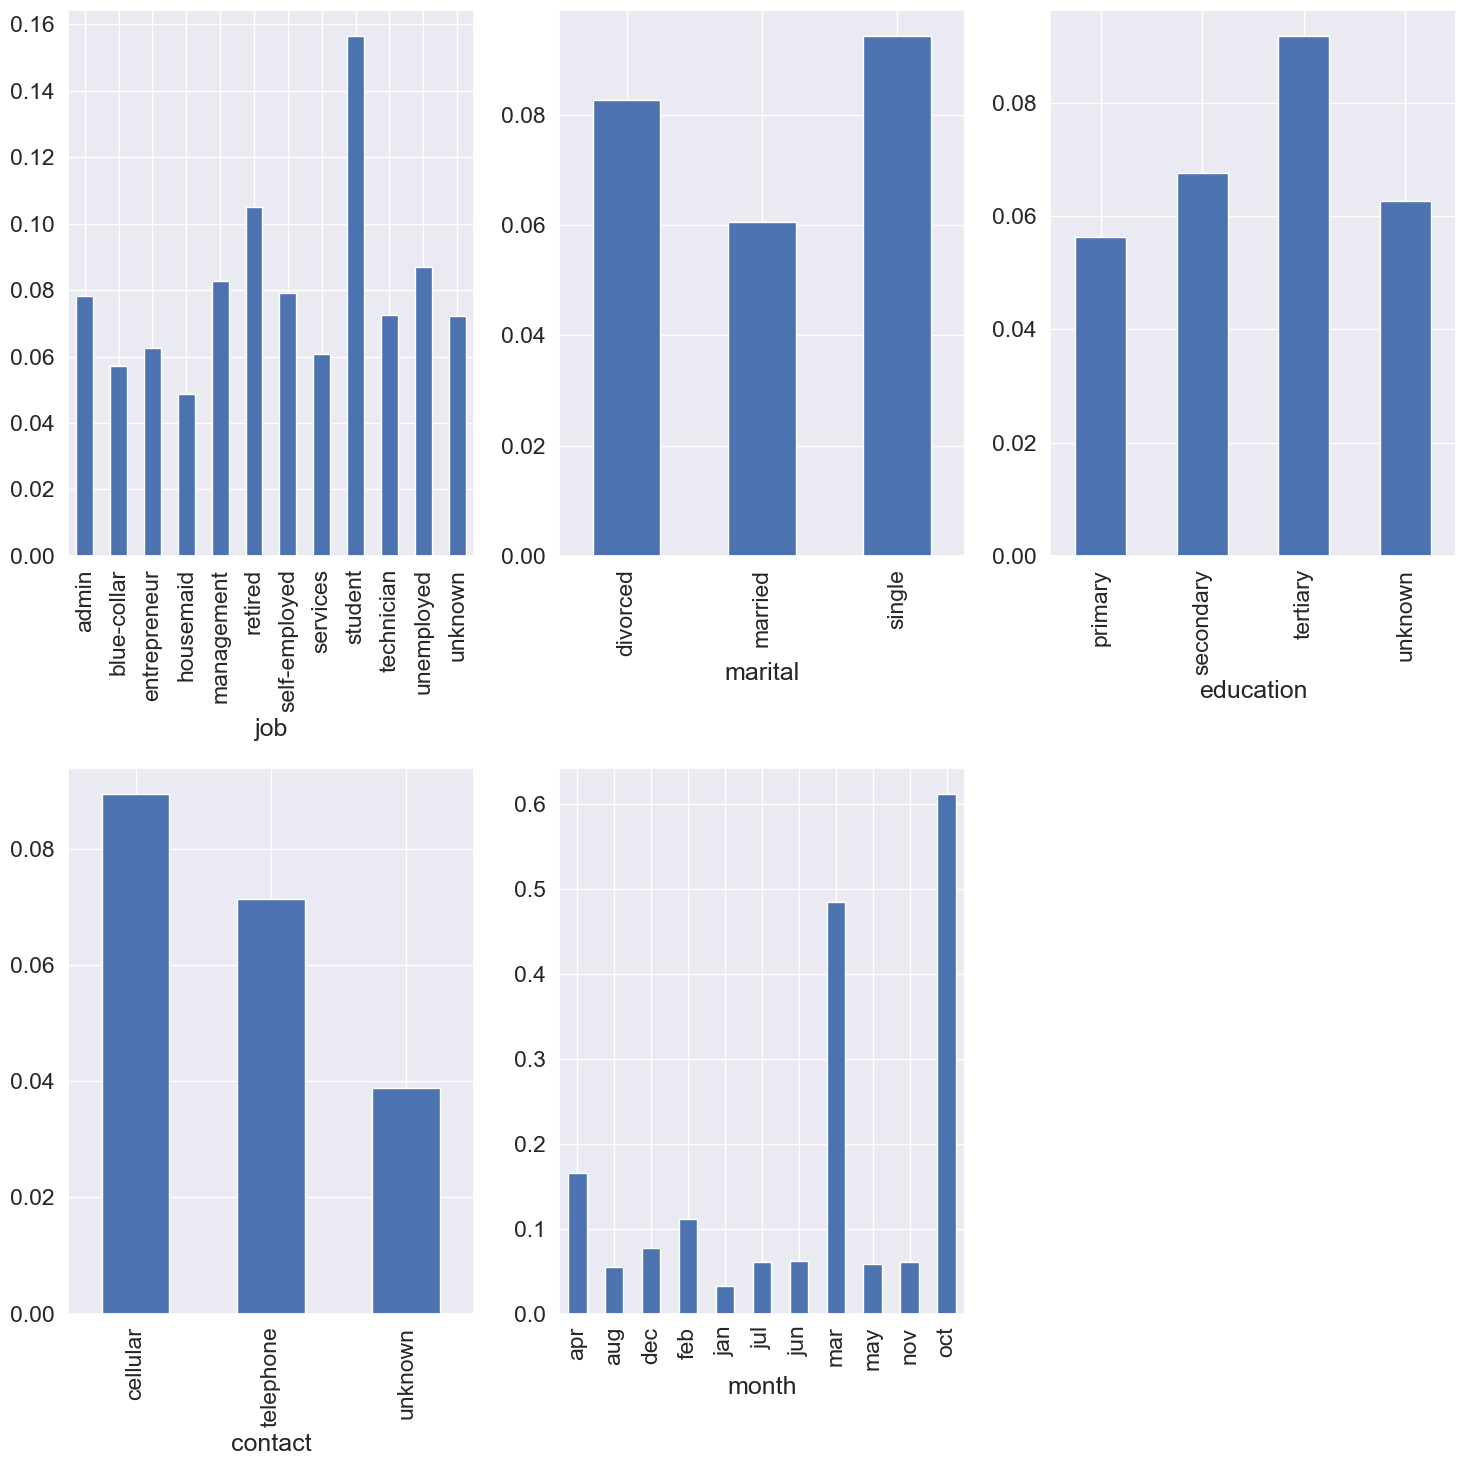

In [18]:
# checking the probability of subscribing to a term deposit using the nominal categorical columns
# barplots of other categorical features based on the corresponding mean value of the target variable

other_cat_cols = ['job', 'marital', 'education', 'contact', 'month']
plt.figure(figsize=(15,15))
i = 1 
for col in other_cat_cols:
  ax = plt.subplot(2,3,i)
  Dataset.groupby([col])['y'].mean().plot.bar()
  i+=1
plt.tight_layout()
plt.show()

* The above shows that a unmarried ('single') 'student' in a 'tertiary' institute and uses a cellular 'contact' line has a higher chance of subscribing to a term deposit in the 'month' of may and oct

In [19]:
# creating a dictionary to represent the contents of the categorical columns in a numeric order

month_dict = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9,'oct': 10, 
              'nov': 11, 'dec': 12}
job_dict = {'management': 12, 'technician':11, 'entrepreneur':10, 'blue-collar':9, 'unknown':8, 'retired':7, 
            'admin':6, 'services':5, 'self-employed':4, 'unemployed':3, 'housemaid':2, 'student':1}
marital_dict = {'married':2, 'single':1, 'divorced':0}
education_dict = {'tertiary':3, 'secondary':2, 'primary':1,'unknown':0}
contact_dict = {'unknown':0, 'cellular':1, 'telephone':2}

# replacing the original values in those columns with their corresponding numeric representation on the dictionary

Dataset['month'] = Dataset.month.map(month_dict)
Dataset['job'] = Dataset.job.map(job_dict)
Dataset['marital'] = Dataset.marital.map(marital_dict)
Dataset['education'] = Dataset.education.map(education_dict)
Dataset['contact'] = Dataset.contact.map(contact_dict)
Dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,12,2,3,0,2143,1,0,0,5,5,261,1,0
1,44,11,1,2,0,29,1,0,0,5,5,151,1,0
2,33,10,2,2,0,2,1,1,0,5,5,76,1,0
3,47,9,2,0,0,1506,1,0,0,5,5,92,1,0
4,33,8,1,0,0,1,0,0,0,5,5,198,1,0


### Correlation of features to target using the Pearson's correlation

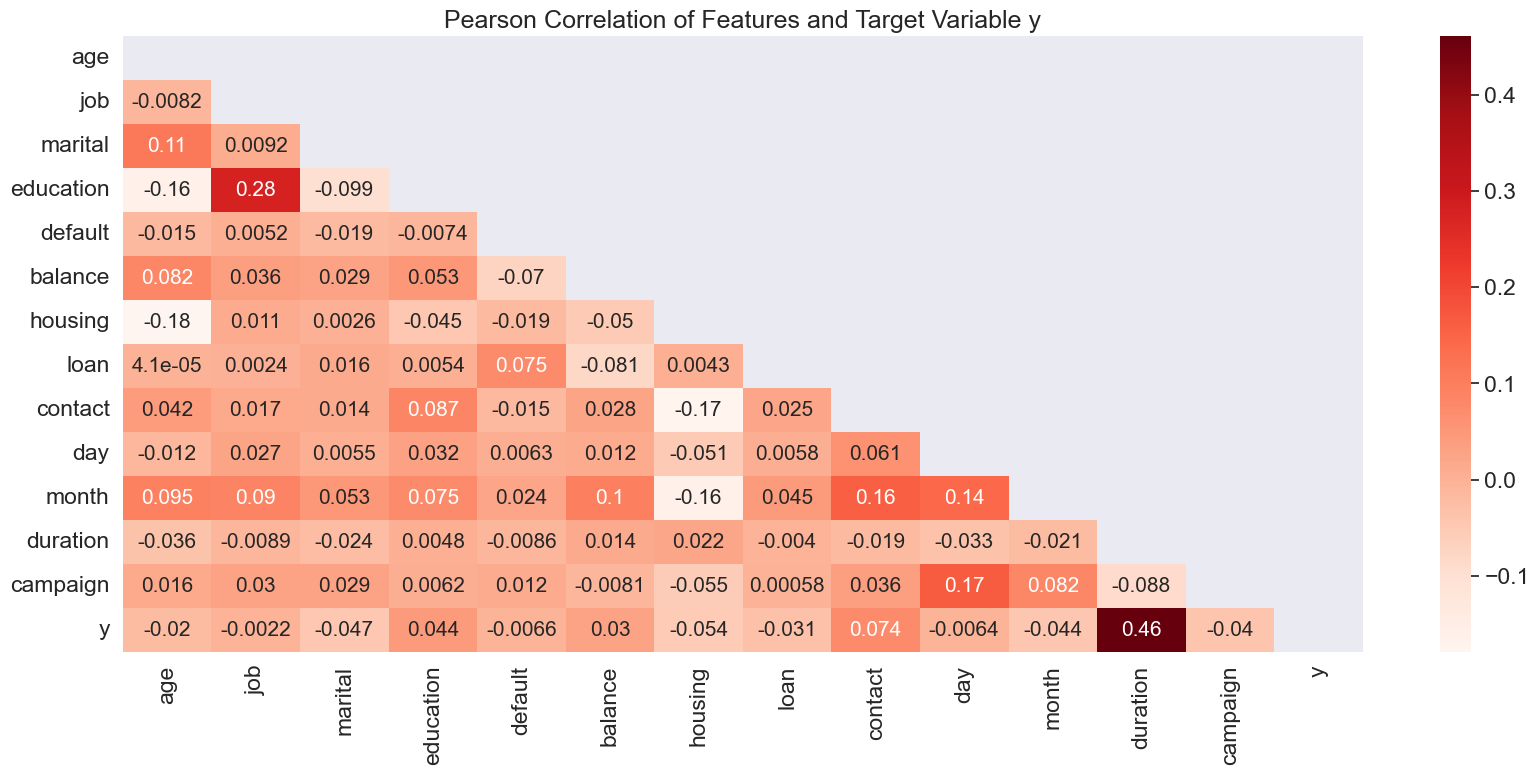

In [20]:
# Correlation Heatmap

sns.set(font_scale=1.5)

# correlation 
cor = Dataset.corr('pearson')
matrix = np.triu(cor)

# heatmap to visualise the correlation
plt.figure(figsize=(20,8))
plt.title('Pearson Correlation of Features and Target Variable y')
sns.heatmap(cor,annot=True, cmap=plt.cm.Reds, mask=matrix,annot_kws={'size': 15})
plt.show()

Observation:from the above heatmap, we see that:
* 'duration', 'contact', 'education', and 'balance' have the strongest correlation respectively to the target 'y'

### Data Preprocessing
* Spliting the Dataset into training and test set
* Balancing the dataset

0   0.93
1   0.07
Name: y, dtype: float64


<AxesSubplot:>

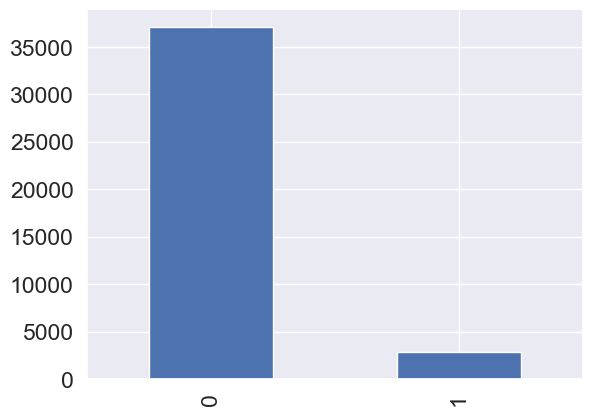

In [21]:
print(Dataset['y'].value_counts(normalize=True))
Dataset['y'].value_counts().plot.bar()

* We see that the dataset is not balanced.
* We will use a SMOTE (Synthetic Minority Oversampling TEchnique) to oversample the minority class (yes:1)

In [22]:
# Splitting the Dataset into training and test set

np.random.seed(1)
X=Dataset.drop('y', axis=1) # defining the features of our dataset
Y=Dataset['y'] # defining the target Y
X_train,X_test,Y_train,Y_test=train_test_split(X,Y, test_size=0.2)

In [23]:
# Let's see the number of samples in each class for our train set.

unique, count =np.unique(Y_train, return_counts=True)
Y_train_dict={ k:v for (k,v) in zip(unique, count)}
Y_train_dict

{0: 29669, 1: 2331}

In [24]:
print("Before OverSampling, counts of label '1': {}".format(sum(Y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(Y_train == 0)))
sm = SMOTE(random_state=0, sampling_strategy = 1.0)
x_train_res, y_train_res = sm.fit_resample(X_train, Y_train)
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

Before OverSampling, counts of label '1': 2331
Before OverSampling, counts of label '0': 29669 

After OverSampling, counts of label '1': 29669
After OverSampling, counts of label '0': 29669


In [25]:
#Print complete list of classifiers
all_classifiers = lazypredict.Supervised.CLASSIFIERS
lazypredict.Supervised.CLASSIFIERS

[('AdaBoostClassifier', sklearn.ensemble._weight_boosting.AdaBoostClassifier),
 ('BaggingClassifier', sklearn.ensemble._bagging.BaggingClassifier),
 ('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
 ('CalibratedClassifierCV', sklearn.calibration.CalibratedClassifierCV),
 ('CategoricalNB', sklearn.naive_bayes.CategoricalNB),
 ('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier),
 ('DummyClassifier', sklearn.dummy.DummyClassifier),
 ('ExtraTreeClassifier', sklearn.tree._classes.ExtraTreeClassifier),
 ('ExtraTreesClassifier', sklearn.ensemble._forest.ExtraTreesClassifier),
 ('GaussianNB', sklearn.naive_bayes.GaussianNB),
 ('KNeighborsClassifier',
  sklearn.neighbors._classification.KNeighborsClassifier),
 ('LabelPropagation',
  sklearn.semi_supervised._label_propagation.LabelPropagation),
 ('LabelSpreading', sklearn.semi_supervised._label_propagation.LabelSpreading),
 ('LinearDiscriminantAnalysis',
  sklearn.discriminant_analysis.LinearDiscriminantAnalysis),
 ('Linear

In [26]:
# select the classifiers we want to test
lazypredict.Supervised.CLASSIFIERS = lazypredict.Supervised.CLASSIFIERS[5:5]
lazypredict.Supervised.CLASSIFIERS.append(all_classifiers[5])
lazypredict.Supervised.CLASSIFIERS.append(all_classifiers[10])
lazypredict.Supervised.CLASSIFIERS.append(all_classifiers[21]) 
lazypredict.Supervised.CLASSIFIERS.append(all_classifiers[25]) 
lazypredict.Supervised.CLASSIFIERS.append(all_classifiers[27]) 
lazypredict.Supervised.CLASSIFIERS

[('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier),
 ('KNeighborsClassifier',
  sklearn.neighbors._classification.KNeighborsClassifier),
 ('RandomForestClassifier', sklearn.ensemble._forest.RandomForestClassifier),
 ('SVC', sklearn.svm._classes.SVC),
 ('XGBClassifier', xgboost.sklearn.XGBClassifier)]

In [27]:
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(x_train_res, X_test, y_train_res, Y_test)

100%|██████████| 5/5 [01:15<00:00, 15.04s/it]


In [28]:
# Below, the result of base models fitted on our dataset
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.88,0.80,0.80,0.90,64.43
XGBClassifier,0.92,0.77,0.77,0.92,2.04
RandomForestClassifier,0.92,0.76,0.76,0.92,4.95
KNeighborsClassifier,0.89,0.76,0.76,0.90,3.47
DecisionTreeClassifier,0.89,0.72,0.72,0.90,0.27


In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report

In [30]:
def load_model(name):
    if name=='DecisionTreeClassifier':
        model=DecisionTreeClassifier()
    elif name=='RandomForestClassifier':
        model=RandomForestClassifier()
    elif name=='KNeighborsClassifier':
        model=KNeighborsClassifier()    
    elif name=='SVC':
        model=SVC() 
    return model

In [31]:
list_models = ['DecisionTreeClassifier', 'RandomForestClassifier', 'KNeighborsClassifier']

dict_models = dict()
dict_models.fromkeys(list_models)

{'DecisionTreeClassifier': None,
 'RandomForestClassifier': None,
 'KNeighborsClassifier': None}

In [32]:
np.random.seed(0)
for model in list_models:
    modele =load_model(model)
    modele.fit(X_train,Y_train)
    sc_train=modele.score(x_train_res, y_train_res)
    sc_test=modele.score(X_test,Y_test)
    dict_models[model]=modele
       
    print("score of on training ",model,"is :",sc_train,)
    Y_pred = dict_models[model].predict(X_test)
    print("\n report of the model: ", model,"\n", classification_report(Y_test, Y_pred),"\n")

score of on training  DecisionTreeClassifier is : 0.7985102295325087

 report of the model:  DecisionTreeClassifier 
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      7435
           1       0.42      0.43      0.43       565

    accuracy                           0.92      8000
   macro avg       0.69      0.69      0.69      8000
weighted avg       0.92      0.92      0.92      8000
 

score of on training  RandomForestClassifier is : 0.7466041996696889

 report of the model:  RandomForestClassifier 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      7435
           1       0.62      0.30      0.40       565

    accuracy                           0.94      8000
   macro avg       0.78      0.64      0.69      8000
weighted avg       0.93      0.94      0.93      8000
 

score of on training  KNeighborsClassifier is : 0.7031076207489299

 report of the model:  KNeighborsClass

In [33]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

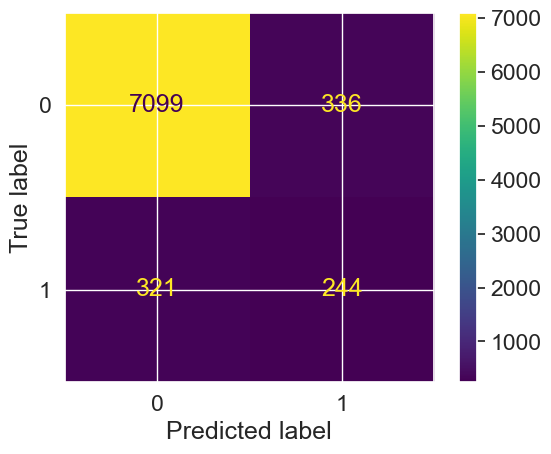

In [34]:
plot_confusion_matrix(dict_models['DecisionTreeClassifier'], X_test, Y_test)  
plt.show()